In [1]:
import pandas as pd
import numpy as np
from sklearn import model_selection
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
import matplotlib.pyplot as plt
import lightgbm as lgb
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

warnings.filterwarnings('ignore')

## Read Train data

In [2]:
train_home_team_statistics_df = pd.read_csv("https://huggingface.co/datasets/bh2821/soccer_pred/resolve/main/train_home_team_statistics_df.csv", index_col=0)
train_away_team_statistics_df = pd.read_csv("https://huggingface.co/datasets/bh2821/soccer_pred/resolve/main/train_away_team_statistics_df.csv", index_col=0)

train_scores = pd.read_csv('https://huggingface.co/datasets/bh2821/soccer_pred/resolve/main/Y_train.csv', index_col=0)

In [3]:
train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_difference = train_home.to_numpy() - train_away.to_numpy()
train_difference_df = pd.DataFrame(train_difference)
train_difference_df.columns = 'DIFF_' + train_home.columns

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home, train_away, train_difference_df], join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})

In [4]:
train_data

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,DIFF_TEAM_YELLOWCARDS_5_last_match_std,DIFF_TEAM_REDCARDS_5_last_match_std,DIFF_TEAM_OFFSIDES_5_last_match_std,DIFF_TEAM_ATTACKS_5_last_match_std,DIFF_TEAM_PENALTIES_5_last_match_std,DIFF_TEAM_SUBSTITUTIONS_5_last_match_std,DIFF_TEAM_BALL_SAFE_5_last_match_std,DIFF_TEAM_DANGEROUS_ATTACKS_5_last_match_std,DIFF_TEAM_INJURIES_5_last_match_std,DIFF_TEAM_GOALS_5_last_match_std
0,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,3.0,6.0,...,-2.0,-5.0,2.0,0.0,4.0,0.0,3.0,-1.0,2.0,0.0
1,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,6.0,8.0,...,4.0,0.0,1.0,2.0,2.0,-4.0,-9.0,2.0,3.0,1.0
2,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,2.0,7.0,...,-2.0,-5.0,2.0,-1.0,6.0,-1.0,-1.0,3.0,-7.0,-2.0
3,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,2.0,0.0,...,4.0,0.0,0.0,6.0,8.0,0.0,-1.0,2.0,NaN,4.0
4,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,4.0,7.0,...,0.0,0.0,-2.0,1.0,-1.0,3.0,1.0,2.0,-2.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,4.0,2.0,3.0,4.0,7.0,4.0,4.0,3.0,2.0,2.0,...,-1.0,-5.0,2.0,4.0,-6.0,-5.0,-1.0,-1.0,NaN,2.0
12299,4.0,2.0,3.0,1.0,5.0,1.0,1.0,9.0,1.0,10.0,...,-1.0,5.0,5.0,0.0,0.0,0.0,2.0,4.0,-3.0,0.0
12300,4.0,3.0,5.0,3.0,5.0,1.0,1.0,6.0,1.0,8.0,...,-1.0,8.0,-3.0,5.0,0.0,0.0,-3.0,-2.0,-1.0,-2.0
12301,2.0,NaN,1.0,1.0,NaN,NaN,NaN,0.0,4.0,2.0,...,8.0,10.0,NaN,6.0,0.0,0.0,-1.0,1.0,NaN,-1.0


In [5]:
crit = train_data.notna().sum(axis=1) > 390

purified_train_data = train_data[crit]
purified_train_data = purified_train_data.fillna(value=0)

purified_train_scores = train_scores[crit]

### I think we need normalization. Make everything within range of [0, 1]

In [6]:
purified_train_data = purified_train_data / 10

In [7]:
purified_train_data

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,DIFF_TEAM_YELLOWCARDS_5_last_match_std,DIFF_TEAM_REDCARDS_5_last_match_std,DIFF_TEAM_OFFSIDES_5_last_match_std,DIFF_TEAM_ATTACKS_5_last_match_std,DIFF_TEAM_PENALTIES_5_last_match_std,DIFF_TEAM_SUBSTITUTIONS_5_last_match_std,DIFF_TEAM_BALL_SAFE_5_last_match_std,DIFF_TEAM_DANGEROUS_ATTACKS_5_last_match_std,DIFF_TEAM_INJURIES_5_last_match_std,DIFF_TEAM_GOALS_5_last_match_std
0,0.3,0.2,0.5,0.2,0.1,0.2,0.2,0.5,0.3,0.6,...,-0.2,-0.5,0.2,0.0,0.4,0.0,0.3,-0.1,0.2,0.0
1,0.6,0.8,0.3,0.6,0.5,0.8,0.7,1.0,0.6,0.8,...,0.4,0.0,0.1,0.2,0.2,-0.4,-0.9,0.2,0.3,0.1
2,0.4,0.2,0.5,0.2,0.8,0.1,0.1,0.2,0.2,0.7,...,-0.2,-0.5,0.2,-0.1,0.6,-0.1,-0.1,0.3,-0.7,-0.2
3,0.7,0.5,0.5,0.6,0.6,0.9,0.9,0.2,0.2,0.0,...,0.4,0.0,0.0,0.6,0.8,0.0,-0.1,0.2,0.0,0.4
4,0.3,0.3,0.2,0.3,0.4,0.4,0.3,0.4,0.4,0.7,...,0.0,0.0,-0.2,0.1,-0.1,0.3,0.1,0.2,-0.2,-0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12296,0.0,0.0,0.0,0.0,0.0,0.8,0.8,0.7,0.0,0.3,...,-0.7,-1.0,-0.1,0.0,-0.5,-0.6,0.0,-0.2,-0.4,0.0
12298,0.4,0.2,0.3,0.4,0.7,0.4,0.4,0.3,0.2,0.2,...,-0.1,-0.5,0.2,0.4,-0.6,-0.5,-0.1,-0.1,0.0,0.2
12299,0.4,0.2,0.3,0.1,0.5,0.1,0.1,0.9,0.1,1.0,...,-0.1,0.5,0.5,0.0,0.0,0.0,0.2,0.4,-0.3,0.0
12300,0.4,0.3,0.5,0.3,0.5,0.1,0.1,0.6,0.1,0.8,...,-0.1,0.8,-0.3,0.5,0.0,0.0,-0.3,-0.2,-0.1,-0.2


### Data Augmentation

In [8]:
def data_augmentation(append_on, df, func, name):
    df_new = append_on
    for c in df.columns:
        df_new[c+name] = func(df[c])
    return df_new

In [9]:
auged_train_data = purified_train_data.copy()

In [10]:
auged_train_data = data_augmentation(auged_train_data, (purified_train_data + 2), np.log10, "_log")
auged_train_data = data_augmentation(auged_train_data, (purified_train_data + 0), np.square, "_sqre")

### Show data before modelling

In [11]:
auged_train_data

,HOME_TEAM_SHOTS_TOTAL_season_sum,HOME_TEAM_SHOTS_INSIDEBOX_season_sum,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,...,DIFF_TEAM_YELLOWCARDS_5_last_match_std_sqre,DIFF_TEAM_REDCARDS_5_last_match_std_sqre,DIFF_TEAM_OFFSIDES_5_last_match_std_sqre,DIFF_TEAM_ATTACKS_5_last_match_std_sqre,DIFF_TEAM_PENALTIES_5_last_match_std_sqre,DIFF_TEAM_SUBSTITUTIONS_5_last_match_std_sqre,DIFF_TEAM_BALL_SAFE_5_last_match_std_sqre,DIFF_TEAM_DANGEROUS_ATTACKS_5_last_match_std_sqre,DIFF_TEAM_INJURIES_5_last_match_std_sqre,DIFF_TEAM_GOALS_5_last_match_std_sqre
0,0.3,0.2,0.5,0.2,0.1,0.2,0.2,0.5,0.3,0.6,...,0.04,0.25,0.04,0.00,0.16,0.00,0.09,0.01,0.04,0.00
1,0.6,0.8,0.3,0.6,0.5,0.8,0.7,1.0,0.6,0.8,...,0.16,0.00,0.01,0.04,0.04,0.16,0.81,0.04,0.09,0.01
2,0.4,0.2,0.5,0.2,0.8,0.1,0.1,0.2,0.2,0.7,...,0.04,0.25,0.04,0.01,0.36,0.01,0.01,0.09,0.49,0.04
3,0.7,0.5,0.5,0.6,0.6,0.9,0.9,0.2,0.2,0.0,...,0.16,0.00,0.00,0.36,0.64,0.00,0.01,0.04,0.00,0.16
4,0.3,0.3,0.2,0.3,0.4,0.4,0.3,0.4,0.4,0.7,...,0.00,0.00,0.04,0.01,0.01,0.09,0.01,0.04,0.04,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12296,0.0,0.0,0.0,0.0,0.0,0.8,0.8,0.7,0.0,0.3,...,0.49,1.00,0.01,0.00,0.25,0.36,0.00,0.04,0.16,0.00
12298,0.4,0.2,0.3,0.4,0.7,0.4,0.4,0.3,0.2,0.2,...,0.01,0.25,0.04,0.16,0.36,0.25,0.01,0.01,0.00,0.04
12299,0.4,0.2,0.3,0.1,0.5,0.1,0.1,0.9,0.1,1.0,...,0.01,0.25,0.25,0.00,0.00,0.00,0.04,0.16,0.09,0.00
12300,0.4,0.3,0.5,0.3,0.5,0.1,0.1,0.6,0.1,0.8,...,0.01,0.64,0.09,0.25,0.00,0.00,0.09,0.04,0.01,0.04


In [12]:
purified_train_scores

,HOME_WINS,DRAW,AWAY_WINS
0,0,0,1
1,0,1,0
2,0,0,1
3,1,0,0
4,0,1,0
...,...,...,...
12296,1,0,0
12298,0,0,1
12299,0,0,1
12300,0,0,1


In [13]:
purified_train_scores.sum(axis=0)

,0
HOME_WINS,4546
DRAW,2709
AWAY_WINS,3181


## Benchmark

We try to model everything in a -1,0,1 scheme

In [14]:
train_new_y = purified_train_scores["HOME_WINS"] - purified_train_scores["AWAY_WINS"]

Convert to 0, 1, 2 scheme for lightGBM

In [15]:
train_new_y = train_new_y + 1

### train, valid test split

In [16]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(auged_train_data, train_new_y, train_size=0.8, random_state=2821)
X_train_mt, X_test_mt, y_train_mt, y_test_mt = model_selection.train_test_split(auged_train_data, purified_train_scores, train_size=0.8, random_state=2821)


### lightGBM model

In [17]:
lgb_train = lgb.Dataset(X_train, label=y_train, free_raw_data=False)
lgb_eval  = lgb.Dataset(X_test,  label=y_test, reference=lgb_train, free_raw_data=False)

params = {
    'boosting_type': 'gbdt',         # Gradient Boosting Decision Tree, the classic tree-based boosting algorithm
    'objective': 'multiclass',       # Multi-class classification task
    'num_class': 3,                  # Number of target classes
    'metric': ['multi_logloss',      # Logarithmic loss for multi-class
               'multi_error'],       # Multi-class classification error rate
    'learning_rate': 0.1,            # Step size shrinkage to prevent overfitting
    'num_leaves': 31,                # Maximum number of leaves in one tree
    'max_depth': -1,                 # No limit on tree depth (-1 means no constraint)
    'feature_fraction': 0.8,         # Proportion of features to consider at each split
    'bagging_fraction': 0.8,         # Proportion of data to use for each iteration (subsample)
    'bagging_freq': 5,               # Perform bagging (subsampling) every 5 iterations
    'verbose': -1                    # Suppress LightGBM output (only warnings and errors will show)
}

# LightGBM params
# Accuracy : 0.5052681992337165
# F1 Score : 0.43713007178786634


In [18]:
# Best parameters obtained from Bayes search

best_params = {
    'colsample_bytree': 0.9527052583177562,  # Subsample ~95.27% of features for each tree to reduce correlation
    'learning_rate': 0.01,                   # Use a small learning rate of 0.01 for stable convergence
    'max_depth': 8,                          # Limit tree depth to 8 to prevent overfitting
    'n_estimators': 207,                     # Total number of trees (boosting rounds)
    'num_leaves': 56,                        # Maximum number of leaves per tree, balancing complexity
    'subsample': 0.7167668562465368          # Use ~71.68% of data per iteration for bagging effect
}

params.update({
    'learning_rate':    best_params['learning_rate'],
    'num_leaves':       best_params['num_leaves'],
    'max_depth':        best_params['max_depth'],
    'feature_fraction': best_params['colsample_bytree'],
    'bagging_fraction': best_params['subsample']
})

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[185]	train's multi_logloss: 0.779167	train's multi_error: 0.241974	eval's multi_logloss: 1.01448	eval's multi_error: 0.501916
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[189]	train's multi_logloss: 0.77025	train's multi_error: 0.230954	eval's multi_logloss: 1.01482	eval's multi_error: 0.497605
Seed 1000 Confusion Matrix：
 [[269  17 330]
 [150  20 371]
 [148  23 760]]


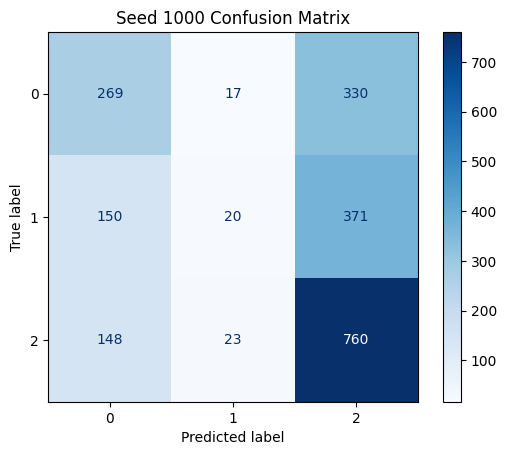

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	train's multi_logloss: 0.896418	train's multi_error: 0.297317	eval's multi_logloss: 1.02272	eval's multi_error: 0.492816
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[49]	train's multi_logloss: 0.893476	train's multi_error: 0.29528	eval's multi_logloss: 1.02209	eval's multi_error: 0.491858
Seed 1001 Confusion Matrix：
 [[281  25 310]
 [159  39 343]
 [160  30 741]]


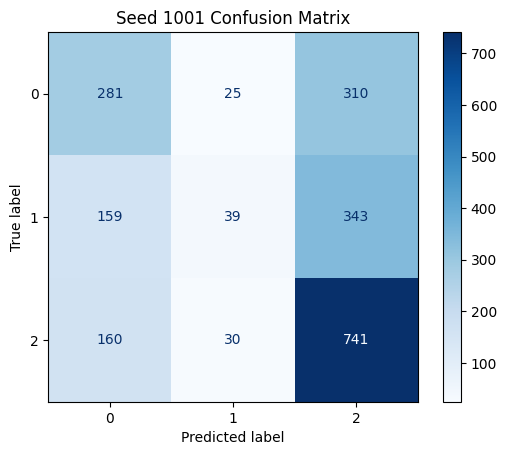

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	train's multi_logloss: 0.779498	train's multi_error: 0.214183	eval's multi_logloss: 1.01137	eval's multi_error: 0.506705
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[99]	train's multi_logloss: 0.770846	train's multi_error: 0.207595	eval's multi_logloss: 1.01133	eval's multi_error: 0.502395
Seed 1002 Confusion Matrix：
 [[266  41 309]
 [163  31 347]
 [149  40 742]]


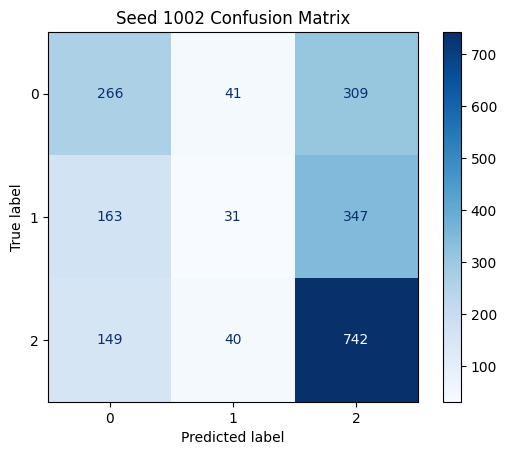

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[13]	train's multi_logloss: 1.0258	train's multi_error: 0.366555	eval's multi_logloss: 1.06158	eval's multi_error: 0.502395
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[108]	train's multi_logloss: 0.751583	train's multi_error: 0.197413	eval's multi_logloss: 1.01582	eval's multi_error: 0.510536
Seed 1003 Confusion Matrix：
 [[270  33 313]
 [166  36 339]
 [176  39 716]]


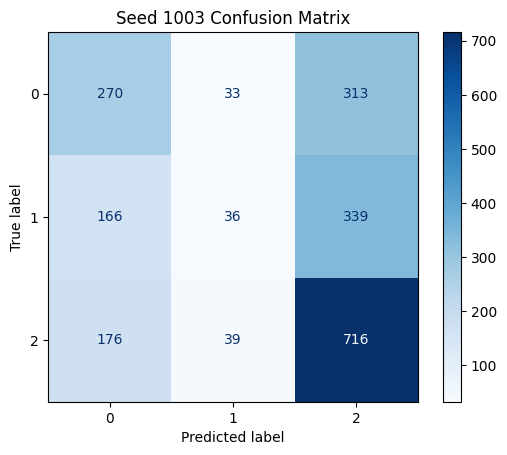

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[48]	train's multi_logloss: 0.895701	train's multi_error: 0.29528	eval's multi_logloss: 1.02309	eval's multi_error: 0.495211
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[128]	train's multi_logloss: 0.710799	train's multi_error: 0.169142	eval's multi_logloss: 1.01348	eval's multi_error: 0.494253
Seed 1004 Confusion Matrix：
 [[286  29 301]
 [160  41 340]
 [151  51 729]]


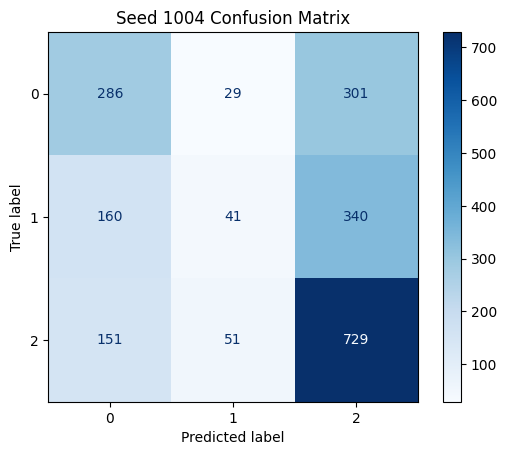

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[57]	train's multi_logloss: 0.869513	train's multi_error: 0.28953	eval's multi_logloss: 1.02014	eval's multi_error: 0.497605
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[88]	train's multi_logloss: 0.794731	train's multi_error: 0.235146	eval's multi_logloss: 1.01477	eval's multi_error: 0.49569
Seed 1005 Confusion Matrix：
 [[286  27 303]
 [158  34 349]
 [159  39 733]]


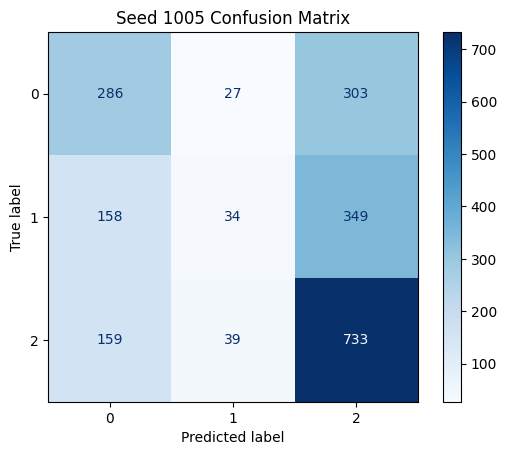

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[61]	train's multi_logloss: 0.860983	train's multi_error: 0.270125	eval's multi_logloss: 1.01827	eval's multi_error: 0.492816
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[71]	train's multi_logloss: 0.835186	train's multi_error: 0.251078	eval's multi_logloss: 1.01621	eval's multi_error: 0.488506
Seed 1006 Confusion Matrix：
 [[288  32 296]
 [155  38 348]
 [145  44 742]]


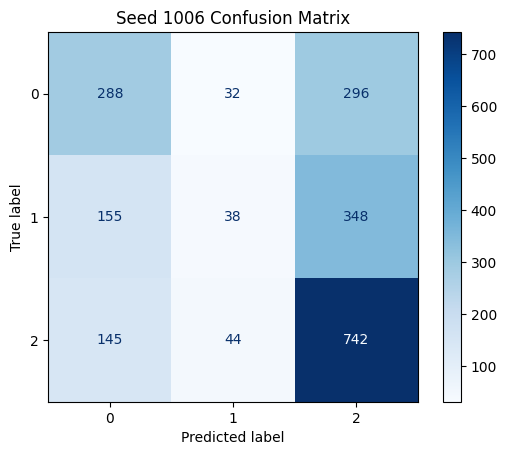

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	train's multi_logloss: 0.810562	train's multi_error: 0.239099	eval's multi_logloss: 1.01609	eval's multi_error: 0.493295
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[83]	train's multi_logloss: 0.805937	train's multi_error: 0.233709	eval's multi_logloss: 1.01604	eval's multi_error: 0.495211
Seed 1007 Confusion Matrix：
 [[288  19 309]
 [160  23 358]
 [144  44 743]]


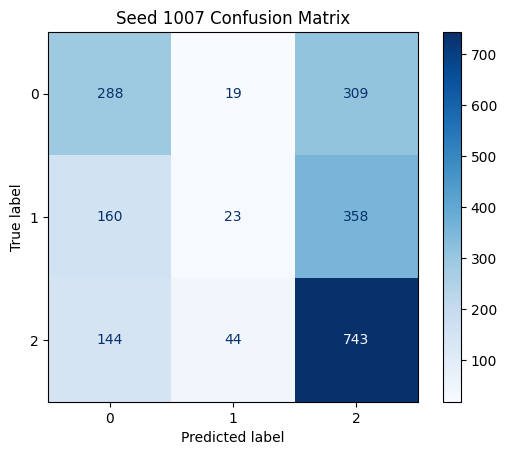

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[35]	train's multi_logloss: 0.93738	train's multi_error: 0.323311	eval's multi_logloss: 1.03361	eval's multi_error: 0.492816
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[107]	train's multi_logloss: 0.753891	train's multi_error: 0.203881	eval's multi_logloss: 1.01412	eval's multi_error: 0.496648
Seed 1008 Confusion Matrix：
 [[280  35 301]
 [153  41 347]
 [151  50 730]]


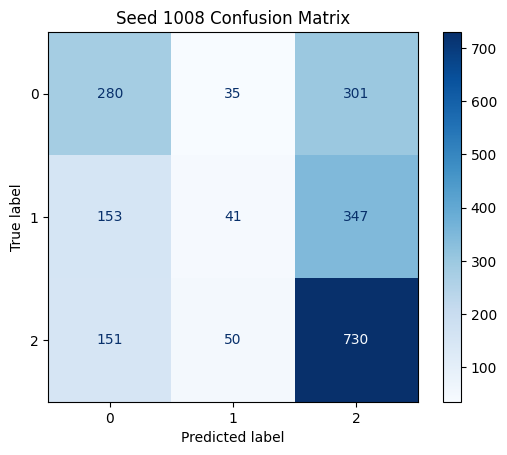

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[30]	train's multi_logloss: 0.956856	train's multi_error: 0.337566	eval's multi_logloss: 1.03744	eval's multi_error: 0.499042
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[36]	train's multi_logloss: 0.935519	train's multi_error: 0.327743	eval's multi_logloss: 1.03063	eval's multi_error: 0.491858
Seed 1009 Confusion Matrix：
 [[279  28 309]
 [144  38 359]
 [143  44 744]]


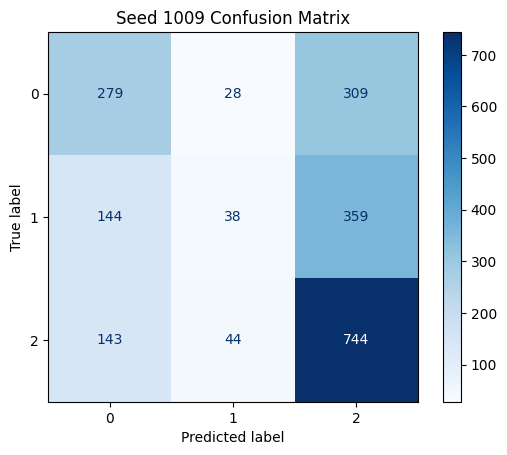

In [19]:
seeds = list(range(1000, 1010))
accs, precs, recs, f1s = [], [], [], []

for seed in seeds:
    params['seed'] = seed

    gbm_0 = lgb.train(
        params,
        lgb_train,
        num_boost_round=500,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=['train','eval'],
        callbacks=[ lgb.early_stopping(stopping_rounds=100) ]
    )

    params['learning_rate'] = 0.02

    gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=500,
        valid_sets=[lgb_train, lgb_eval],
        valid_names=['train','eval'],
        init_model=gbm_0,
        callbacks=[ lgb.early_stopping(stopping_rounds=200) ]
    )

    y_prob = gbm.predict(X_test)
    y_pred = np.argmax(y_prob, axis=1)
    y_true = y_test

    accs.append(accuracy_score(y_true, y_pred))
    precs.append(precision_score(y_true, y_pred, average='weighted', zero_division=0))
    recs.append(recall_score(y_true, y_pred, average='weighted', zero_division=0))
    f1s.append(f1_score(y_true, y_pred, average='weighted', zero_division=0))

    cm = confusion_matrix(y_true, y_pred)
    print(f"Seed {seed} Confusion Matrix：\n", cm)

    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Seed {seed} Confusion Matrix")
    plt.show()


In [20]:
metrics = {
    'Accuracy':  np.array(accs),
    'Precision': np.array(precs),
    'Recall':    np.array(recs),
    'F1-score':  np.array(f1s)
}

for name, vals in metrics.items():
    mean = vals.mean()
    std  = vals.std(ddof=1)
    print(f"{name}: mean = {mean:.4f}, std = {std:.4f}")

# Accuracy: mean = 0.5035, std = 0.0062
# Precision: mean = 0.4615, std = 0.0118
# Recall: mean = 0.5035, std = 0.0062
# F1-score: mean = 0.4469, std = 0.0079

Accuracy: mean = 0.5035, std = 0.0062
Precision: mean = 0.4615, std = 0.0118
Recall: mean = 0.5035, std = 0.0062
F1-score: mean = 0.4469, std = 0.0079
